In [ ]:
#    train/test splits
import os
from pathlib import Path
import random
import shutil

random.seed(42)

INPUT_ROOT = Path("/kaggle/input")
WORK_ROOT  = Path("/kaggle/working/dataset")  # will create symlinked train/test here
TRAIN_OUT  = WORK_ROOT / "train"
TEST_OUT   = WORK_ROOT / "test"
SPLIT_RATIO = 0.82   # fraction for train, rest -> test

def find_candidate_datasets(input_root, min_classes=2, max_levels=3):
    """
    """
    candidates = []
    for child in input_root.iterdir():
        
        for level in range(max_levels):
            p = child
            for _ in range(level):
             
                subs = [d for d in p.iterdir() if d.is_dir()]
                if len(subs)==1:
                    p = subs[0]
                else:
                    break
        
            if p.exists() and any(p.iterdir()):
                subdirs = [d for d in p.iterdir() if d.is_dir()]
                if len(subdirs) >= min_classes:
                    candidates.append(p)
 
    uniq = []
    for c in candidates:
        if c not in uniq:
            uniq.append(c)
    return uniq

cands = find_candidate_datasets(INPUT_ROOT, min_classes=2, max_levels=4)
print("Detected candidate dataset roots under /kaggle/input (possible class-folder roots):")
for i,c in enumerate(cands):
    print(f"{i+1}. {c}   (subfolders: {len([d for d in c.iterdir() if d.is_dir()])})")

if not cands:
    raise FileNotFoundError("No candidate dataset found under /kaggle/input. Make sure you added the dataset in the Notebook 'Add data' panel.")

 
dataset_root = cands[0]
print("\n--> Using dataset root:", dataset_root)

#   train/test split
has_train = (dataset_root / "train").is_dir()
has_test  = (dataset_root / "test").is_dir()

if has_train and has_test:
    print("Dataset already contains 'train' and 'test' folders. Using them directly.")
    TRAIN_DIR = dataset_root / "train"
    TEST_DIR  = dataset_root / "test"
else:
    print("No explicit train/test found. Will create symlinked split in:", WORK_ROOT)
    TRAIN_DIR = TRAIN_OUT
    TEST_DIR  = TEST_OUT
    # create output dirs
    TRAIN_DIR.mkdir(parents=True, exist_ok=True)
    TEST_DIR.mkdir(parents=True, exist_ok=True)

    # for each class in dataset_root, create class subfolders in train/test and symlink files
    classes = sorted([d for d in dataset_root.iterdir() if d.is_dir()])
    if not classes:
        raise FileNotFoundError(f"No class subfolders found in candidate dataset root: {dataset_root}")

    for cls_dir in classes:
        cls_name = cls_dir.name
        files = sorted([p for p in cls_dir.iterdir() if p.is_file()])
        if not files:
            print(f"Warning: no files in class {cls_name}, skipping")
            continue
        random.shuffle(files)
        split_at = int(len(files) * SPLIT_RATIO)
        train_files = files[:split_at]
        test_files  = files[split_at:]
        # make target class dirs
        (TRAIN_DIR / cls_name).mkdir(parents=True, exist_ok=True)
        (TEST_DIR  / cls_name).mkdir(parents=True, exist_ok=True)

        # create symlink (or copy fallback) for train files
        for src in train_files:
            dst = TRAIN_DIR / cls_name / src.name
            if not dst.exists():
                try:
                    os.symlink(src, dst)
                except Exception as e:
                    # fallback to copy
                    shutil.copy2(src, dst)
        # test files
        for src in test_files:
            dst = TEST_DIR / cls_name / src.name
            if not dst.exists():
                try:
                    os.symlink(src, dst)
                except Exception as e:
                    shutil.copy2(src, dst)
    print("Finished creating symlinked train/test split (or copying if symlink failed).")

# Print class counts
def counts(folder):
    folder = Path(folder)
    classes = sorted([d for d in folder.iterdir() if d.is_dir()])
    result = {}
    for c in classes:
        n = sum(1 for _ in c.iterdir() if _.is_file())
        result[c.name] = n
    return result

train_counts = counts(TRAIN_DIR)
test_counts  = counts(TEST_DIR)
all_classes = sorted(set(list(train_counts.keys()) + list(test_counts.keys())))
print("\nClass                Train      Test       Total")
print("-"*60)
total_train = total_test = 0
for c in all_classes:
    t = train_counts.get(c,0)
    te = test_counts.get(c,0)
    total_train += t
    total_test  += te
    print(f"{c:18s} {t:8d} {te:11d} {t+te:11d}")
print("-"*60)
print(f"TOTAL {total_train:18d} {total_test:11d} {total_train+total_test:11d}")

# Final variables for your training code
print("\nSet these variables in your notebook for ImageFolder:")
print("TRAIN_DIR  =", TRAIN_DIR)
print("TEST_DIR   =", TEST_DIR)


Detected candidate dataset roots under /kaggle/input (possible class-folder roots):
1. /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage   (subfolders: 11)

--> Using dataset root: /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage
No explicit train/test found. Will create symlinked split in: /kaggle/working/dataset
Finished creating symlinked train/test split (or copying if symlink failed).

Class                Train      Test       Total
------------------------------------------------------------
Tomato___Bacterial_spot     1395         307        1702
Tomato___Early_blight      656         144         800
Tomato___Late_blight     1252         275        1527
Tomato___Leaf_Mold      624         137         761
Tomato___Septoria_leaf_spot     1161         256        1417
Tomato___Spider_mites Two-spotted_spider_mite     1099         242        1341
Tomato___Target_Spot      920         203        1123
Tomato___Tomato_Yellow_Leaf_Curl_Virus     3514         772    

Classes (train): ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Class to idx: {'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}
Train samples: 11909
Test  samples: 2620

Number of train batches: 373
Number of test  batches: 82
Batch size: 32
Images tensor shape: torch.Size([32, 3, 224, 224])
Labels tensor shape: torch.Size([32])
Label -> class (first 8): ['Tomato___Septoria_leaf_spot', 'Tomato___Leaf_Mold', 'Tomato___healthy', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 

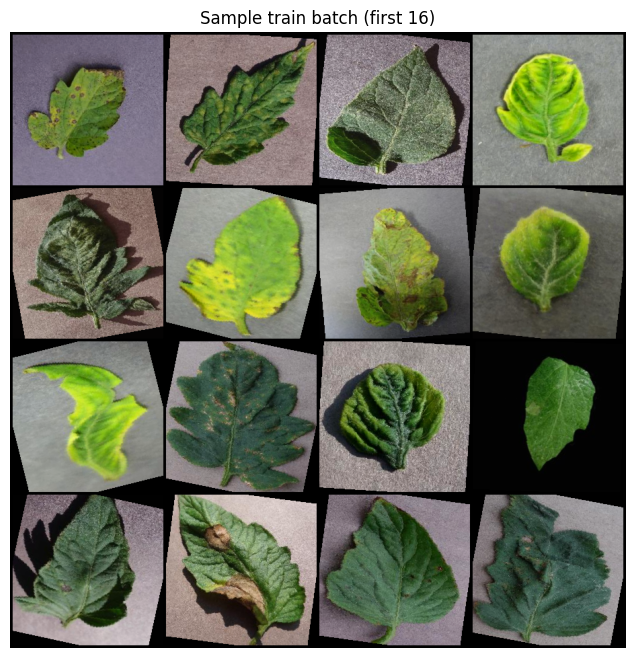

In [5]:
# build ImageFolder, DataLoader, show sample batch
# Run this AFTER your detection/split cell completed.

from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch
import matplotlib.pyplot as plt

# --- UPDATE path if your helper printed different TRAIN_DIR / TEST_DIR ---
TRAIN_DIR = Path("/kaggle/working/dataset/train")
TEST_DIR  = Path("/kaggle/working/dataset/test")

IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2  

# transforms (augmentation only on train)
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.08, contrast=0.08, saturation=0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# create ImageFolder datasets
train_dataset = datasets.ImageFolder(str(TRAIN_DIR), transform=train_transforms)
test_dataset  = datasets.ImageFolder(str(TEST_DIR),  transform=val_transforms)

print("Classes (train):", train_dataset.classes)
print("Class to idx:", train_dataset.class_to_idx)
print("Train samples:", len(train_dataset))
print("Test  samples:", len(test_dataset))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print(f"\nNumber of train batches: {len(train_loader)}")
print(f"Number of test  batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")

# sample one batch and show shapes + labels
batch = next(iter(train_loader))
images, labels = batch
print("Images tensor shape:", images.shape)   # expected [BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE]
print("Labels tensor shape:", labels.shape)

idx_to_class = {v:k for k,v in train_dataset.class_to_idx.items()}
print("Label -> class (first 8):", [idx_to_class[int(x)] for x in labels[:8]])

# denormalize for plotting
mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
imgs = images.clone().cpu() * std + mean
grid = make_grid(imgs[:16], nrow=4, padding=4)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Sample train batch (first 16)")
plt.imshow(grid.permute(1,2,0).clip(0,1))
plt.show()


In [7]:
# =======================
#  VIT MODEL CELL 
# =======================

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import timm

# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- Number of Classes ----
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

# ---- Load Vision Transformer (ViT-B/16) ----
model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)
print("Model loaded on:", device)

# ---- Loss function ----
criterion = nn.CrossEntropyLoss()

# ---- Optimizer ----
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# ---- Scheduler (optional but recommended) ----
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ---- Model Summary ----
print("\n========== MODEL SUMMARY ==========")
summary(model, input_size=(1, 3, 224, 224))


Using device: cuda
Number of classes: 10
Model loaded on: cuda

========== MODEL SUMMARY ==========


Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 10]                   152,064
├─PatchEmbed: 1-1                        [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Identity: 2-2                     [1, 196, 768]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─Identity: 1-3                          [1, 197, 768]             --
├─Identity: 1-4                          [1, 197, 768]             --
├─Sequential: 1-5                        [1, 197, 768]             --
│    └─Block: 2-3                        [1, 197, 768]             --
│    │    └─LayerNorm: 3-1               [1, 197, 768]             1,536
│    │    └─Attention: 3-2               [1, 197, 768]             2,362,368
│    │    └─Identity: 3-3                [1, 197, 768]             --
│    │    └─Identity: 3-4                [1, 197, 768]           

 TRAINING STARTED (ViT-B/16)
 Saving best model to: /kaggle/working/best_vit_model.pth
 Epochs: 40, Patience: 6
Epoch [1/40] Train Loss: 0.2546 | Train Acc: 91.59% || Val Loss: 0.1125 | Val Acc: 96.15%
  BEST UPDATED! Saved (Acc: 96.15%)
Epoch [2/40] Train Loss: 0.0756 | Train Acc: 97.62% || Val Loss: 0.0875 | Val Acc: 97.06%
  BEST UPDATED! Saved (Acc: 97.06%)
Epoch [3/40] Train Loss: 0.0593 | Train Acc: 98.04% || Val Loss: 0.0493 | Val Acc: 98.28%
  BEST UPDATED! Saved (Acc: 98.28%)
Epoch [4/40] Train Loss: 0.0410 | Train Acc: 98.64% || Val Loss: 0.0324 | Val Acc: 98.97%
  BEST UPDATED! Saved (Acc: 98.97%)
Epoch [5/40] Train Loss: 0.0250 | Train Acc: 99.27% || Val Loss: 0.0527 | Val Acc: 98.44%
Epoch [6/40] Train Loss: 0.0139 | Train Acc: 99.46% || Val Loss: 0.0242 | Val Acc: 99.31%
  BEST UPDATED! Saved (Acc: 99.31%)
Epoch [7/40] Train Loss: 0.0096 | Train Acc: 99.73% || Val Loss: 0.0109 | Val Acc: 99.69%
  BEST UPDATED! Saved (Acc: 99.69%)
Epoch [8/40] Train Loss: 0.0029 | Train Ac

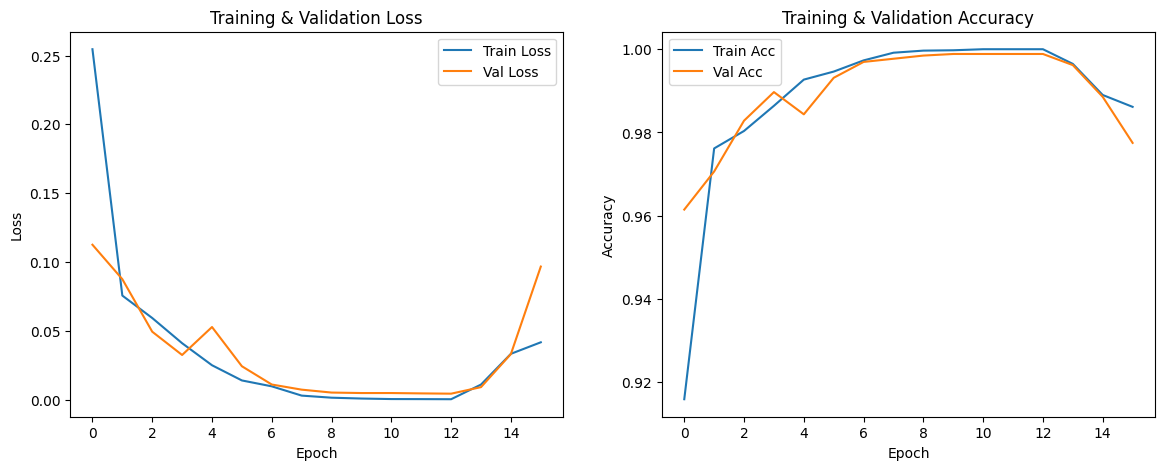

  Training plot saved to: /kaggle/working/vit_training_history.png


In [9]:
# ===========================
# TRAINING LOOP (ViT)
# ===========================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

EPOCHS = 40
PATIENCE = 6   # early stopping patience
best_val_acc = 0
epochs_no_improve = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

print("========================================")
print(" TRAINING STARTED (ViT-B/16)")
print("========================================")
print(f" Saving best model to: /kaggle/working/best_vit_model.pth")
print(f" Epochs: {EPOCHS}, Patience: {PATIENCE}")
print("========================================")

for epoch in range(1, EPOCHS+1):

    # ---------------- TRAIN ----------------
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    # ---------------- VALID ----------------
    model.eval()
    total, correct, running_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc  = correct / total

    # Log history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Print progress
    print(f"Epoch [{epoch}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% "
          f"|| Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Scheduler
    scheduler.step()

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "/kaggle/working/best_vit_model.pth")
        print(f"  BEST UPDATED! Saved (Acc: {val_acc*100:.2f}%)")
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= PATIENCE:
        print(" Early stopping activated!")
        break

print("========================================")
print("  TRAINING COMPLETE!")
print(f"  Best Validation Accuracy: {best_val_acc*100:.2f}%")
print("========================================")


# =====================
# PLOT TRAINING CURVES
# =====================
plt.figure(figsize=(14,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig("/kaggle/working/vit_training_history.png")
plt.show()

print("  Training plot saved to: /kaggle/working/vit_training_history.png")


Loaded best model: /kaggle/working/best_vit_model.pth
  TEST ACCURACY: 99.89%

CLASSIFICATION REPORT

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     1.0000    1.0000    1.0000       307
                        Tomato___Early_blight     1.0000    0.9861    0.9930       144
                         Tomato___Late_blight     0.9928    1.0000    0.9964       275
                           Tomato___Leaf_Mold     1.0000    0.9927    0.9963       137
                  Tomato___Septoria_leaf_spot     1.0000    1.0000    1.0000       256
Tomato___Spider_mites Two-spotted_spider_mite     0.9959    1.0000    0.9979       242
                         Tomato___Target_Spot     1.0000    1.0000    1.0000       203
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     1.0000    1.0000    1.0000       772
                 Tomato___Tomato_mosaic_virus     1.0000    1.0000    1.0000        54
                           

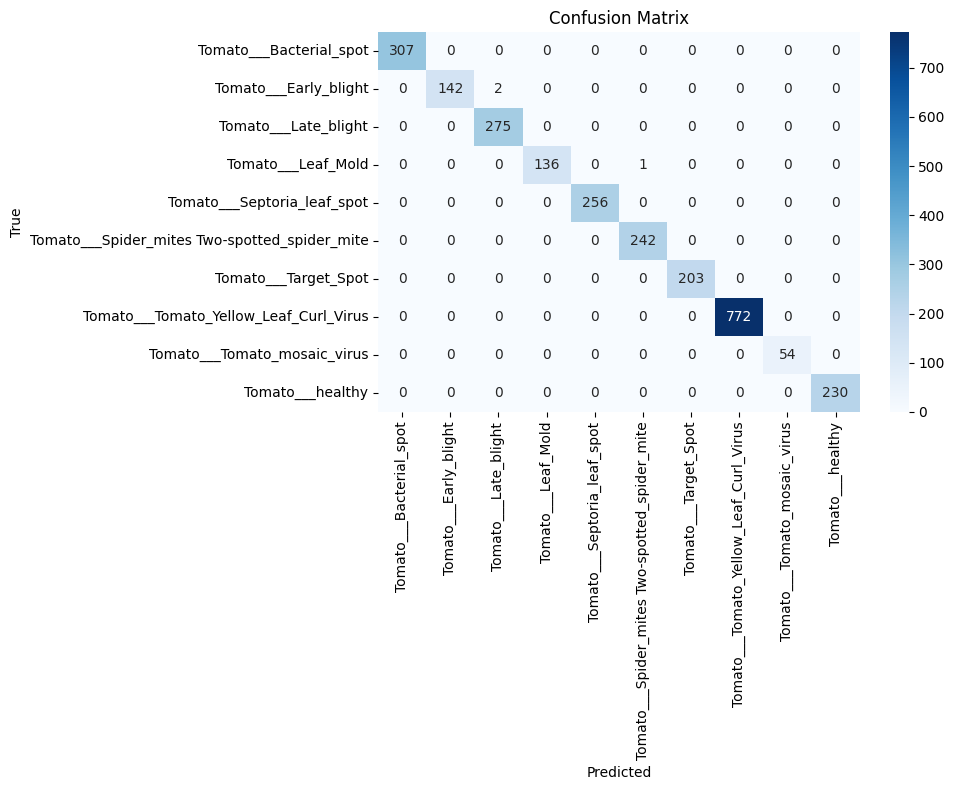

Saved confusion matrix to: /kaggle/working/vit_confusion_matrix.png

Per-class accuracy:
Tomato___Bacterial_spot  : 100.00%
Tomato___Early_blight    : 98.61%
Tomato___Late_blight     : 100.00%
Tomato___Leaf_Mold       : 99.27%
Tomato___Septoria_leaf_spot: 100.00%
Tomato___Spider_mites Two-spotted_spider_mite: 100.00%
Tomato___Target_Spot     : 100.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100.00%
Tomato___Tomato_mosaic_virus: 100.00%
Tomato___healthy         : 100.00%

Saved per-class accuracy to: /kaggle/working/vit_per_class_accuracy.csv
Saved predictions to: /kaggle/working/test_predictions.csv


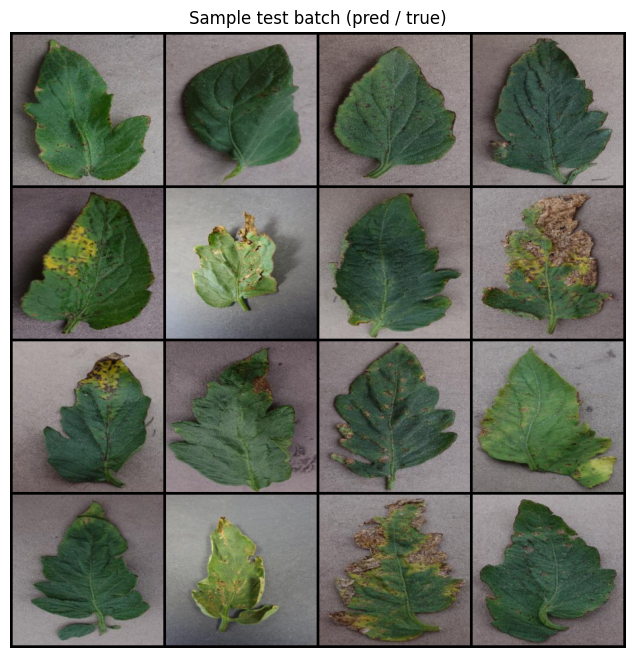

Predictions (first 16):
['Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot']
Ground truth (first 16):
['Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot', 'Tomato___Bacterial_spot']


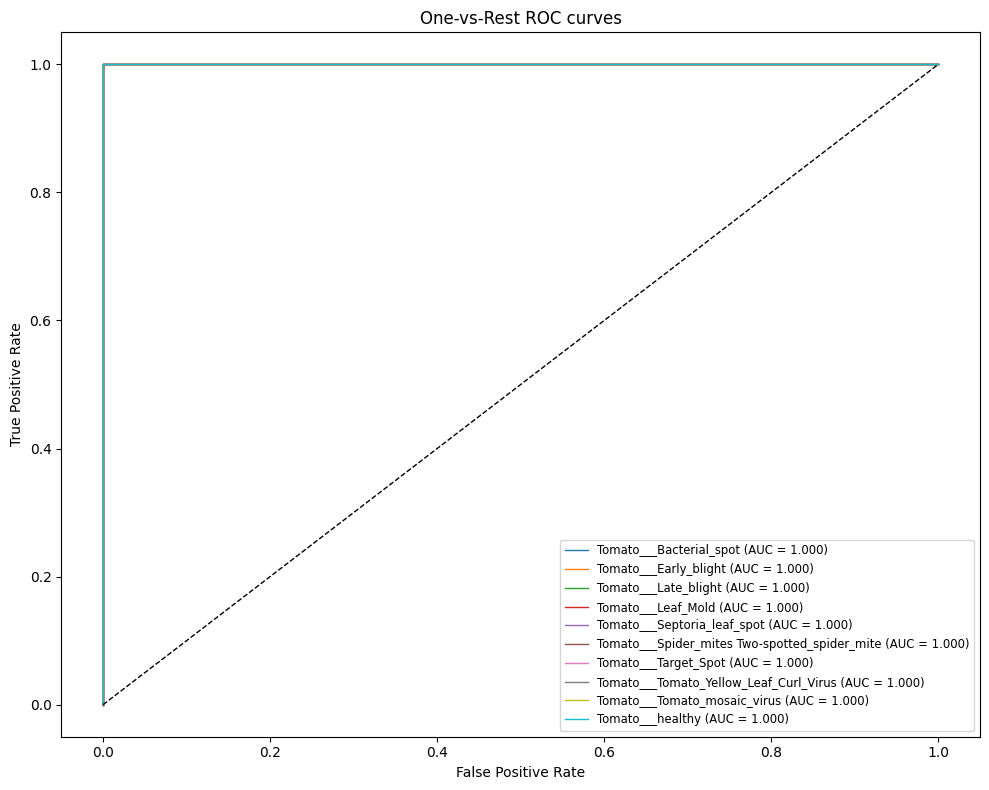

Saved ROC curves to: /kaggle/working/vit_roc_curves.png

ALL evaluation outputs saved under /kaggle/working/


In [ ]:
# =========================
#   EVALUATION 
# =========================
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from torchvision.utils import make_grid
import os

# --- SETTINGS ---
BEST_MODEL_PATH = "/kaggle/working/best_vit_model.pth"
OUT_DIR = Path("/kaggle/working")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- load best model weights ---
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()
print("Loaded best model:", BEST_MODEL_PATH)

# --- run on test set and collect preds ---
all_labels = []
all_preds = []
all_probs = []   
filenames = []

softmax = torch.nn.Softmax(dim=1)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        probs = softmax(outputs).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())
        # try to capture filenames if dataset supports it
        try:
            # test_loader.dataset is ImageFolder -> samples contain (path, class)
            start = batch_idx * test_loader.batch_size
            # slice filenames from dataset.samples
            for i in range(images.size(0)):
                idx = start + i
                path = test_loader.dataset.samples[idx][0]
                filenames.append(os.path.basename(path))
        except Exception:
            filenames.extend([f"img_{len(filenames)+i}" for i in range(images.size(0))])

# stack probs
all_probs = np.vstack(all_probs) if len(all_probs) else np.zeros((len(all_preds), len(train_dataset.classes)))

# --- basic metrics ---
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
acc = accuracy_score(y_true, y_pred)
print("========================================")
print(f"  TEST ACCURACY: {acc*100:.2f}%")
print("========================================\n")

# --- classification report ---
target_names = train_dataset.classes
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("CLASSIFICATION REPORT\n")
print(report)

# save report to file
with open(OUT_DIR / "vit_classification_report.txt", "w") as f:
    f.write("Test Accuracy: {:.4f}\n\n".format(acc))
    f.write(report)

# --- confusion matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(OUT_DIR / "vit_confusion_matrix.png")
plt.show()
print("Saved confusion matrix to:", OUT_DIR / "vit_confusion_matrix.png")

# --- per-class accuracy ---
per_class_acc = {}
for i, cls in enumerate(target_names):
    idxs = np.where(y_true == i)[0]
    if len(idxs) == 0:
        per_class_acc[cls] = None
    else:
        per_class_acc[cls] = (y_pred[idxs] == y_true[idxs]).sum() / len(idxs)

print("\nPer-class accuracy:")
for cls, v in per_class_acc.items():
    if v is None:
        print(f"{cls:25s}: no samples")
    else:
        print(f"{cls:25s}: {v*100:.2f}%")

# save per-class to csv
pd.DataFrame.from_dict(per_class_acc, orient="index", columns=["accuracy"]).to_csv(OUT_DIR / "vit_per_class_accuracy.csv")
print("\nSaved per-class accuracy to:", OUT_DIR / "vit_per_class_accuracy.csv")

# --- Save detailed predictions CSV ---
df = pd.DataFrame({
    "filename": filenames[:len(y_true)],
    "true_label": [train_dataset.classes[i] for i in y_true],
    "pred_label": [train_dataset.classes[i] for i in y_pred],
})
# add top-3 predictions with probs
topk = 3
topk_idx = np.argsort(-all_probs, axis=1)[:, :topk]
for k in range(topk):
    df[f"pred_{k+1}"] = [train_dataset.classes[i] for i in topk_idx[:, k]]
    df[f"pred_{k+1}_prob"] = all_probs[np.arange(len(all_probs)), topk_idx[:, k]]
df.to_csv(OUT_DIR / "test_predictions.csv", index=False)
print("Saved predictions to:", OUT_DIR / "test_predictions.csv")

# --- sample predictions grid (first 16) ---
try:
    sample_imgs, sample_labels = next(iter(test_loader))
    sample_preds = model(sample_imgs.to(device))
    sample_probs = softmax(sample_preds).cpu()
    sample_preds_idx = sample_probs.argmax(dim=1).numpy()
    # denormalize for display
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    imgs = sample_imgs.clone().cpu() * std + mean
    grid = make_grid(imgs[:16], nrow=4, padding=4)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0).clip(0,1))
    plt.axis('off')
    plt.title("Sample test batch (pred / true)")
    plt.show()

    # print class names below
    print("Predictions (first 16):")
    print([train_dataset.classes[i] for i in sample_preds_idx[:16]])
    print("Ground truth (first 16):")
    print([train_dataset.classes[int(i)] for i in sample_labels[:16].numpy()])
except Exception as e:
    print("Could not show sample grid:", e)

# --- ROC curves ---
try:
    n_classes = len(target_names)
    y_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro and macro
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # plot
    plt.figure(figsize=(10,8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1, label=f"{target_names[i]} (AUC = {roc_auc[i]:.3f})")
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curves")
    plt.legend(loc="lower right", fontsize="small")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "vit_roc_curves.png")
    plt.show()
    print("Saved ROC curves to:", OUT_DIR / "vit_roc_curves.png")
except Exception as e:
    print("Skipping ROC curves (error):", e)

print("\nALL evaluation outputs saved under /kaggle/working/")


Model on device: cuda:0
Classes count: 10

0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_Bact.Sp 6254.JPG
  Tomato___Bacterial_spot                  100.00%
  Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.00%
  Tomato___Target_Spot                       0.00%


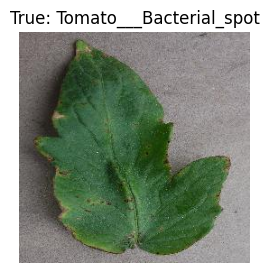


014b58ae-091b-408a-ab4a-5a780cd1c3f3___GCREC_Bact.Sp 2971.JPG
  Tomato___Bacterial_spot                  100.00%
  Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.00%
  Tomato___Septoria_leaf_spot                0.00%


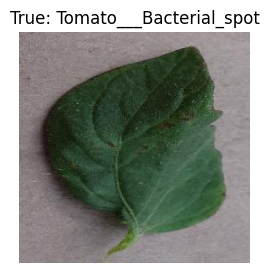


0296e043-c805-47e4-bce5-b2326048ac67___GCREC_Bact.Sp 5680.JPG
  Tomato___Bacterial_spot                  100.00%
  Tomato___Target_Spot                       0.00%
  Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.00%


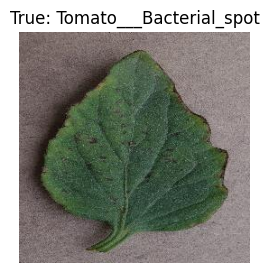


02dfe58f-0ad1-4bf6-838a-e145978b1eed___GCREC_Bact.Sp 5841.JPG
  Tomato___Bacterial_spot                  100.00%
  Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.00%
  Tomato___Target_Spot                       0.00%


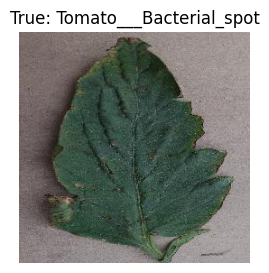


045e9a8d-bed0-4700-8d27-7f8d0735223e___GCREC_Bact.Sp 3848.JPG
  Tomato___Bacterial_spot                   99.99%
  Tomato___Septoria_leaf_spot                0.00%
  Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.00%


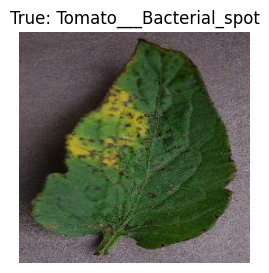


07238109-52ed-4369-b16c-6f5844858b81___UF.GRC_BS_Lab Leaf 0447.JPG
  Tomato___Bacterial_spot                   99.89%
  Tomato___Septoria_leaf_spot                0.06%
  Tomato___Early_blight                      0.04%


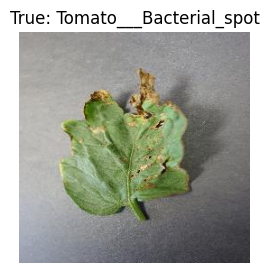

In [26]:
# predict_image and see outputs for a few test images
import matplotlib.pyplot as plt
from PIL import Image
import os

# --- CONFIG ---
NUM_SAMPLES = 6   
TOP_K = 3

# make sure model and train_dataset exist
print("Model on device:", next(model.parameters()).device)
print("Classes count:", len(train_dataset.classes))

# gather sample paths from test dataset
sample_paths = []
try:
    samples = test_loader.dataset.samples  
    for p, _ in samples[:NUM_SAMPLES]:
        sample_paths.append(p)
except Exception as e:
    print("Could not get sample paths from test loader:", e)

if not sample_paths:
    print("No sample paths found. Provide an explicit image path to test predict_image().")
else:
    for p in sample_paths:
        try:
            preds = predict_image(p, model=model, class_names=train_dataset.classes, k=TOP_K, device=device)
        except Exception as e:
            print(f"Error running predict_image on {p}: {e}")
            continue

        # print filename and predictions
        print("\n" + os.path.basename(p))
        for cname, prob in preds:
            print(f"  {cname:40s} {prob*100:6.2f}%")

        # display the image with true label (if available)
        try:
            img = Image.open(p).convert("RGB")
            true_idx = None
            # find true class using ImageFolder mapping
            for s_path, s_idx in test_loader.dataset.samples:
                if s_path == p:
                    true_idx = s_idx
                    break
            title = f"True: {train_dataset.classes[true_idx]}" if true_idx is not None else ""
            plt.figure(figsize=(3,3))
            plt.imshow(img)
            plt.axis('off')
            plt.title(title)
            plt.show()
        except Exception as e:
            print("Could not open/display image:", e)
